In [1]:
import jax.numpy as jnp
from jax import nn
import numpy as np
from matplotlib import pyplot as plt

from descent_methods import GD, SGD, SGD_adagrad, SGD_RMS_prop, SGD_adam, new_SGD_adam
from utilities import MSELoss_method, jax_loss_grad, feature_matrix, train_test_split

In [2]:
# simple function
def f(x):
    return x + x**2

def FrankeFunction(x,y):
  term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
  term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
  term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
  term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
  return term1 + term2 + term3 + term4# + np.random.normal(scale=0.1,size=x.shape)


def feature_matrix_2d(x, y, num_features):
    """
    Generates a feature matrix based on x, y and the number of features.
    
    The function constructs features by taking combinations of powers of x and y,
    starting with the highest power of x.

    x: A 2D array with a single column of input values.
    y: A 2D array with a single column of input values.
    num_features: The number of feature columns.

    X: The feature matrix,a 2D numpy array with a column for each feature
    """
    X = np.zeros((len(x), num_features))

    deg = 0
    n   = 0
    while True:
        for i in range(0, deg+1):

            # Add feature row
            X[:,n] = x[:, 0]**(deg-i) * y[:, 0]**i

            # Increment number of points done, and end if needed
            n += 1
            if n == num_features:
                
                return X

        deg += 1


def r2_sampling(num_points, sigma2 = 0):
    """
    To add noise, input sigma2 > 0.
    """

    x = np.random.random(( num_points, 1))
    y = np.random.random((num_points, 1))

    z = FrankeFunction(x, y) + np.random.normal(0, np.sqrt(sigma2), size=(num_points, 1))

    return {'x':x, 'y':y, 'z':z}

In [3]:
def sigmoid(x):
    return 1 / (1+jnp.exp(-x))

def relu(x):
    return jnp.maximum(0, x)

def leaky_relu(x, alpha = 0.5):
    return jnp.maximum(0, x) + alpha*jnp.minimum(x, 0)

def leaky_relu_stochastic(x, alpha_min=0, alpha_max=1):
    alpha = np.random.uniform(alpha_min, alpha_max)
    return leaky_relu(x, alpha=alpha)

In [4]:

num_points = 100

layers = [6 ,6, 6, 7, 1]

x = np.random.random((num_points, 1))*2
y = f(x)
beta0 = {}
for i in range(1,len(layers)):
    beta0[f"W{i}"] = np.random.random((layers[i-1], layers[i]))
    beta0[f"b{i}"] = np.random.random()

def neural_network(beta, X, activation = nn.sigmoid):
    out = X.copy()
    for i in range(1, len(beta.keys())//2):
        #print(f'{out.shape} + {beta[f"W{i}"].shape}')

        out = activation(jnp.add(jnp.dot(out, beta[f"W{i}"]), beta[f"b{i}"]))
        
        #out = jnp.dot(out, beta[f"W{i}"])
    out_final = jnp.add(jnp.dot(out, beta[f"W{len(beta.keys())//2}"]), beta[f"b{len(beta.keys())//2}"])
    #print(out.shape)
    return out_final


#beta0 = {"W1":np.random.random((num_params, 1))}

data = r2_sampling(num_points, sigma2=0.3)
x, y, z = data["x"], data["y"], data["z"]

X = feature_matrix_2d(x, y, layers[0])

#X = feature_matrix(x, layers[0])

print(neural_network(beta0, X).shape)


def model(beta, X):
    return jnp.dot(X, beta["W1"])

loss_func = MSELoss_method(neural_network)

loss_grad = jax_loss_grad(loss_func)


(100, 1)


### Plain GD

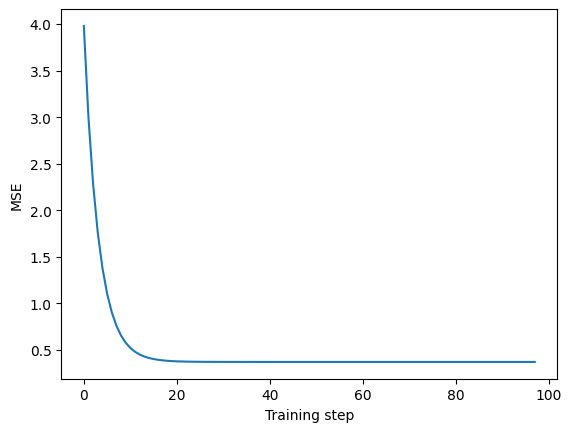

In [5]:

result_sgd = GD(grad_method=loss_grad, X=X, y=z, beta0=beta0, n_epochs=100, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_sgd["loss_list"]

plt.plot(loss_list[3:])
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Stochastic

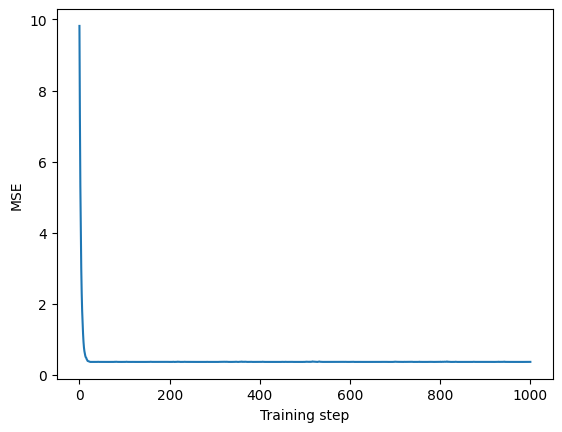

In [6]:

result_sgd = SGD(grad_method=loss_grad, X=X, y=z, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_sgd["loss_list"]


plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Adagrad

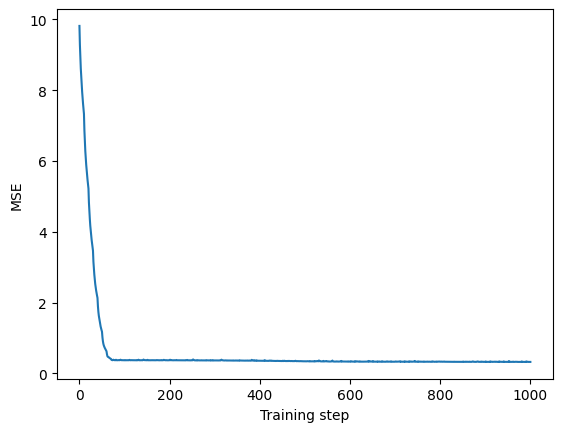

In [7]:

result_adagrad = SGD_adagrad(grad_method=loss_grad, X=X, y=z, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_adagrad["loss_list"]


plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### RMS prop

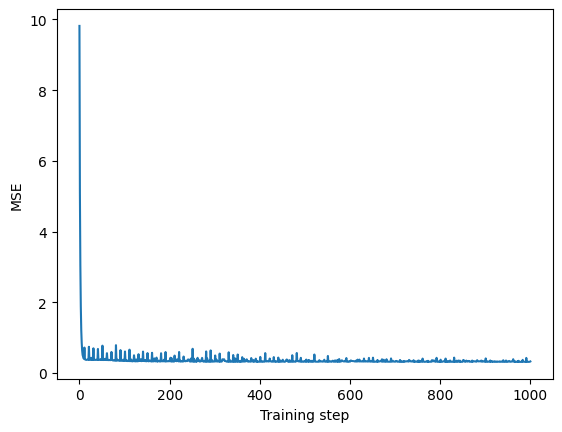

In [8]:

result_rms = SGD_RMS_prop(grad_method=loss_grad, X=X, y=z, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_rms["loss_list"]

plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Adam

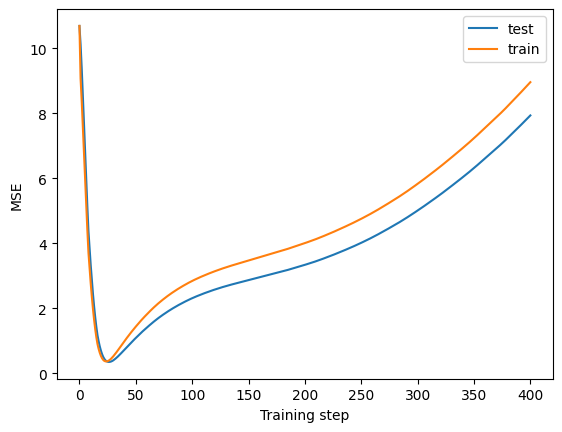

In [9]:
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2)


result_adam = new_SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad, beta0=beta0, test_loss_func=loss_func)


test_loss_list = result_adam["test_loss_list"]
train_loss_list = result_adam["train_loss_list"]

plt.plot(test_loss_list, label = "test")
plt.plot(train_loss_list, label = "train")
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [10]:
result_adam

{'train_loss_list': [Array(10.684748, dtype=float32),
  Array(9.07036, dtype=float32),
  Array(8.381942, dtype=float32),
  Array(7.6089478, dtype=float32),
  Array(6.7975893, dtype=float32),
  Array(5.9781084, dtype=float32),
  Array(5.177813, dtype=float32),
  Array(4.4177833, dtype=float32),
  Array(3.7101398, dtype=float32),
  Array(3.2216344, dtype=float32),
  Array(2.7671158, dtype=float32),
  Array(2.351506, dtype=float32),
  Array(1.9790093, dtype=float32),
  Array(1.647527, dtype=float32),
  Array(1.3572578, dtype=float32),
  Array(1.1096603, dtype=float32),
  Array(0.90283805, dtype=float32),
  Array(0.75589985, dtype=float32),
  Array(0.63624704, dtype=float32),
  Array(0.5414618, dtype=float32),
  Array(0.4693915, dtype=float32),
  Array(0.41811275, dtype=float32),
  Array(0.38582844, dtype=float32),
  Array(0.3699028, dtype=float32),
  Array(0.3679917, dtype=float32),
  Array(0.3767218, dtype=float32),
  Array(0.39380127, dtype=float32),
  Array(0.4181963, dtype=float32),
 